## CODE
#### Imports


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle
import seg_metrics.seg_metrics as sg
import pandas as pd

#### User Input Data


In [2]:
path_training_dataset = "D:\\Work\\Sarbazi\\data\\all_data_LAT\\training"
path_testing_dataset = "D:\\Work\\Sarbazi\\data\\all_data_LAT\\testing"
batch_size = 2
femur_locator = True
if femur_locator:
    # for femur locator
    image_shape = (1024//2, 1024//2)
    crop_enabled = False
    naugment = 1
else:
    # for accurate segmentation
    image_shape = (1024//2, 768//2)
    crop_enabled = True
    naugment = 4

#### Data Generation


In [3]:
MyUtils = reload(MyUtils)
training_data = MyUtils.DataGenerator(path_training_dataset, batch_size, image_shape, crop_enabled, naugment, True, True)
testing_data = MyUtils.DataGenerator(path_testing_dataset, batch_size, image_shape, crop_enabled, naugment, False, True)

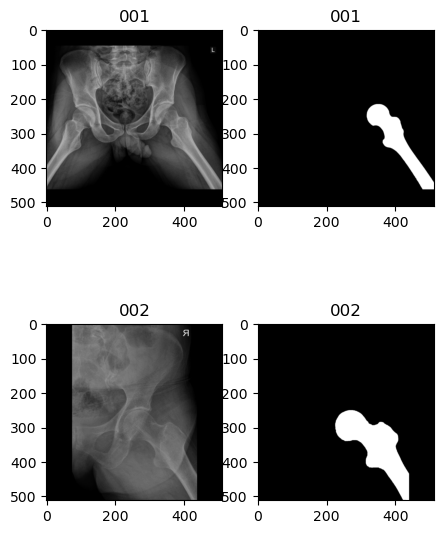

In [4]:
batch_id = 0
sample_batch_image, sample_batch_mask = training_data.__getitem__(batch_id)
img_ids = training_data._get_image_ids(batch_id)
fig, ax = plt.subplots(sample_batch_image.shape[0], 2, figsize=(5, 7))
for i in range(sample_batch_image.shape[0]):
    ax[i, 0].imshow(sample_batch_image[i,:,:,0],cmap='gray')
    ax[i, 0].set_title(str(img_ids[i//naugment]).zfill(3))
    ax[i, 1].imshow(sample_batch_mask[i,:,:,0],cmap='gray')
    ax[i, 1].set_title(str(img_ids[i//naugment]).zfill(3))

#### Create U-Net


In [6]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
if femur_locator:
    UNetModel = UNet.create_UNet_locator((*image_shape,1), (*image_shape,1))
else:
    UNetModel = UNet.create_UNet_accurate((*image_shape,1), (*image_shape,1))
UNetModel.compile(optimizer=MyUtils.keras.optimizers.Adam(), loss=MyUtils.binary_cross_entropy_and_dice_coef_loss)
# UNetModel.summary(line_length=120)

In [10]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=50, workers=10, verbose=1)

Epoch 1/50
22/22 [==============================] - 1s 32ms/step - loss: 0.1864 - val_loss: 0.2079
Epoch 2/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1849 - val_loss: 0.2154
Epoch 3/50
22/22 [==============================] - 1s 30ms/step - loss: 0.1810 - val_loss: 0.2069
Epoch 4/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1786 - val_loss: 0.1972
Epoch 5/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1745 - val_loss: 0.1924
Epoch 6/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1715 - val_loss: 0.1956
Epoch 7/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1683 - val_loss: 0.2003
Epoch 8/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1656 - val_loss: 0.1997
Epoch 9/50
22/22 [==============================] - 1s 30ms/step - loss: 0.1630 - val_loss: 0.1898
Epoch 10/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1606 - val_loss: 0.1888
Epoch 11/

In [8]:
if femur_locator:
    UNetModel.save('UNetModel_locator_LAT.h5')
else:
    UNetModel.save('UNetModel_accurate_LAT.h5')

In [6]:
if coarse_network:
    UNetModel = UNet.keras_models.load_model('UNetModel_locator_LAT.h5', custom_objects={"dice_coef_loss": MyUtils.dice_coef_loss, "dice_coef": MyUtils.dice_coef, "binary_cross_entropy_and_dice_coef_loss": MyUtils.binary_cross_entropy_and_dice_coef_loss})
else:
    UNetModel = UNet.keras_models.load_model('UNetModel_accurate_LAT.h5', custom_objects={"dice_coef_loss": MyUtils.dice_coef_loss, "dice_coef": MyUtils.dice_coef, "binary_cross_entropy_and_dice_coef_loss": MyUtils.binary_cross_entropy_and_dice_coef_loss})

1/1 [==============================] - 0s 26ms/step


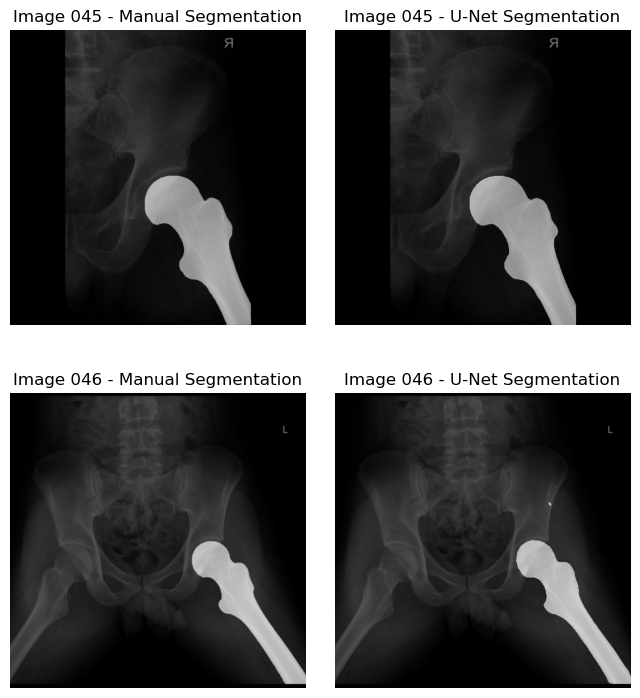

In [23]:
batch_id = 0
sample_test_image, sample_test_mask = testing_data.__getitem__(batch_id)
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.bool_)

fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(8,9))
titles = [str(i).zfill(3) for i in testing_data._get_image_ids(batch_id)]
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,0].set_title("Image %s - Manual Segmentation" % (titles[i//naugment]))
    axs[i,0].axis('off')
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,1].set_title("Image %s - U-Net Segmentation" % (titles[i//naugment]))
    axs[i,1].axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [24]:
# with open('out.png','wb') as f:
#     fig.savefig(f, dpi=600)

## evaluation on selected dataset


In [25]:
eval_data = testing_data
gdth_img = []
pred_img = []
for i in range(len(eval_data)):
    images, masks = eval_data[i]
    predict_segment = UNetModel.predict(images, verbose=0)
    predict_segment = (predict_segment>0.5).astype(np.int_)
    for m in range(masks.shape[0]):
        gdth_img.append(masks[m,:,:,0])
        pred_img.append(predict_segment[m,:,:,0])
labels = [0, 1]
spacing = [0.64, 0.64]
metrics = sg.write_metrics(labels=labels[1:],  # exclude background if needed
                          gdth_img=gdth_img,
                          pred_img=pred_img,
                          spacing=spacing,
                          TPTNFPFN=True)
reshape_metrics = {} 
for m in metrics:
    for k in m.keys():
        try:
            reshape_metrics[k].append(m[k][0])
        except:
            reshape_metrics[k] = []
            reshape_metrics[k].append(m[k][0])


for k in reshape_metrics.keys():
    reshape_metrics[k] = np.array(reshape_metrics[k])

reshape_metrics["nfpr"] = reshape_metrics["FP"] / (reshape_metrics["TP"]+reshape_metrics["FN"])
n = reshape_metrics["TP"] + reshape_metrics["TN"] + reshape_metrics["FP"] + reshape_metrics["FN"]
fa = reshape_metrics["TP"]+reshape_metrics["TN"]
fc = (reshape_metrics["TN"]+reshape_metrics["FN"])*(reshape_metrics["TN"]+reshape_metrics["FP"]) + (reshape_metrics["FP"]+reshape_metrics["TP"])*(reshape_metrics["FN"]+reshape_metrics["TP"])
fc /= n
reshape_metrics["kap"] = (fa-fc)/(n-fc)
reshape_metrics["auc"] = 1-(reshape_metrics["fpr"]+reshape_metrics["fnr"])/2
reshape_metrics["acc"] = (reshape_metrics["TP"]+reshape_metrics["TN"])/n
reshape_metrics["inf"] = 1-reshape_metrics["fnr"]-reshape_metrics["fpr"]
ppv = reshape_metrics["TP"]/(reshape_metrics["TP"]+reshape_metrics["FP"])
npv = reshape_metrics["TN"]/(reshape_metrics["TN"]+reshape_metrics["FN"])
reshape_metrics["mk"] = ppv + npv - 1
reshape_metrics.pop("label")
reshape_metrics.pop("TP")
reshape_metrics.pop("TN")
reshape_metrics.pop("FP")
reshape_metrics.pop("FN")

10it [00:02,  4.23it/s]


array([   4,    0,  143,    3, 2618,   12,    0,    0,    6,    7])

In [26]:
myorder_metrics = {}
for k in ["dice", "jaccard", "acc", "precision", "recall", "fpr", "fnr", "nfpr", "kap", "auc", "inf", "mk", "hd", "msd", "mdsd", "stdsd", "hd95"]:
    myorder_metrics[k] = reshape_metrics[k]
for k in myorder_metrics.keys():
    print("%s" % k)
for k in myorder_metrics.keys():
    print("%.2f \u00B1 %.2f" % (np.round(np.mean(myorder_metrics[k]), decimals=2), np.round(np.std(myorder_metrics[k]), decimals=2)))

dice
jaccard
acc
precision
recall
fpr
fnr
nfpr
kap
auc
inf
mk
hd
msd
mdsd
stdsd
hd95
0.95 ± 0.01
0.91 ± 0.02
0.99 ± 0.00
0.92 ± 0.02
0.99 ± 0.03
0.01 ± 0.00
0.01 ± 0.03
0.09 ± 0.03
0.95 ± 0.01
0.99 ± 0.01
0.98 ± 0.03
0.91 ± 0.02
14.25 ± 14.07
1.49 ± 0.54
1.26 ± 0.13
1.66 ± 1.48
2.95 ± 2.49


In [53]:
df = pd.DataFrame(myorder_metrics)
df.to_csv("locator_network_metrics.csv")